# Transfer Learning with Keras

In this tutorial we'll look at how to utilize Keras and a pretrained model to predict a custom object. This is useful for when you don't want (or don't have the possibility/time) to train a model from scratch and you have a problem that is similar to one with an already existing solution.

The following code is a complete solution from loading a train set to creating train and validation set generators to predicting and checking performance.

We will load an existing model into Keras, remove its final layer and train it on our custom dataset to get image predictions without creating and training a whole network within minutes!

You might need to modify some path variables and your results might not completely match mine due to how training neural nets work, but if you have Keras installed, it should work!

First let's load the packages we're going to need:

In [1]:
import os
import numpy as np
from numpy.random import permutation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Lambda, Dense
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

Using TensorFlow backend.


We're going to use 2 helper functions, read an image into a neural net-friendly format and another one to do this for all images in a folder. We're going to stick to the default resolution of the VGG19 model for ease. Thankfully we have the helper function `preprocess_input` available to us, preparing the input to be compatible with Keras/VGG19.

In [2]:
def process_image(img_path, expand_dims = False, target_size=(224, 224)):
    img = image.load_img(img_path, target_size)
    x = image.img_to_array(img)
    if expand_dims == True: 
        x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [3]:
def parse_images(category, target_size, path = "./"):
    images = []
    i = 0
    for file in sorted(os.listdir(path+category)):
        if file[0] != ".":
            img_path = path+category+"/"+file
            x = process_image(img_path, target_size)
            images.append(x)
    images = np.asarray(images)
    return images


In [293]:
def process_image(image_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

I gathered 10 random images of cats and 10 random images of lightbulbs off Google. Some examples are: 

|Cat 1 |Cat 2|
|---|----|
|![./download.jpeg](attachment:./download.jpeg)|![./Cornish%20Rex%20Cat1.jpg](attachment:./Cornish%20Rex%20Cat1.jpg)|

|Lightbulb 1 |Lightbulb 2 |
|---|----|
|![./e7617f1414cf46e39b8ba9b9009c7b29.jpeg](attachment:./e7617f1414cf46e39b8ba9b9009c7b29.jpeg)|![./s.jpeg](attachment:./s.jpeg)|

The original VGG19 model was trained to predict 1000 categories (in accordance with the [ImageNet Challenge](http://image-net.org/challenges/LSVRC/)) including cats, but we're going to utilise transfer learning to modify it and predict 2 categories: cats and lightbulbs. While cats are a part of the original 1000 categories, lightbulbs are not. With the power of transfer learning, however, we are able to introduce and reliably predict new categories based on this pretrained model.

Let's start with reading the images into Python variables!
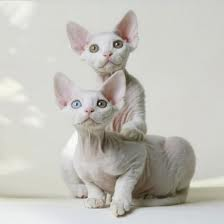
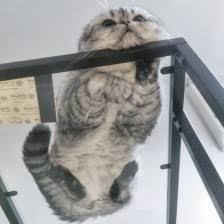
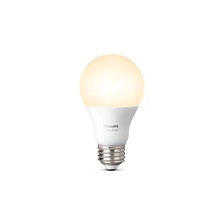
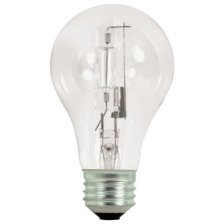

In [4]:
target_size = (224,224)

In [5]:
cats = parse_images("cats", target_size)
bulbs = parse_images("lightbulbs", target_size)

We're marking cats as category 0 and bulbs as category 1, and then combining the images and the categories into a single variable each:

In [6]:
cats_y = np.zeros((len(cats)))
bulbs_y = np.ones((len(cats)))

X = np.vstack((cats, bulbs))
y = np.concatenate((cats_y, bulbs_y))

In [7]:
np.shape(X)

(20, 224, 224, 3)

Now our input `X` has the shape of (20, 224, 224, 3) - we have 20 images, all with the resolution of 224x224 and 3 channels each (RGB color coding).

The target variables (the classes) for the VGG19 model have to be [one-hot encoded](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f), so let's transform our `y`!

In [8]:
train = np.zeros((len(y), 2))
train[np.arange(len(y)), y.astype(int)] = 1
y = train
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

Here, the first column ha the value 1 if the image is a cat and 0 if it isn't. The same applies to column 2 with the image being a lightbulb.

Let's shuffle the input:

In [9]:
perm = permutation(len(y))
X = X[perm]
y = y[perm]

Now we have the input in the format we require. Let's load the pre-trained VGG19 model! We are specifying that we want to use the trained model with the weights for the imagenet dataset. We could also load the model without weights initialized, but that would mean we'd need to retrain the whole model from scratch, and that's the opposite of what we're trying to do with transfer learning. You might get some warnings, but disregard them.

In [10]:
vgg19_model = VGG19(include_top=True, weights='imagenet')


W0827 16:49:51.822905 140736037671808 deprecation_wrapper.py:119] From /Users/csanadpoda/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 16:49:51.852724 140736037671808 deprecation_wrapper.py:119] From /Users/csanadpoda/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 16:49:51.857797 140736037671808 deprecation_wrapper.py:119] From /Users/csanadpoda/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 16:49:51.901552 140736037671808 deprecation_wrapper.py:119] From /Users/csanadpoda/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool

We can use the following command to see the full architecture/summary of the model. As you can see, our final dense layer contains 1000 nodes to predict the 1000 categories. We're going to replace that one specifically and keep everything else.

In [11]:
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Here we're removing the final layer (alternatively you could load the model without this final layer by using `include_top=False`, I just wanted you to see the full original architecture of the network). We then create a new dense laayer with 2 nodes (for our two categories: cats and lightbulbs) and specify the inputs and outputs for our new custom model. Then we check the summary: we can see that the architecture is completely the same except for the final layer (the one responsible for predictions).

In [12]:
vgg19_model.layers.pop()
new_layer = Dense(2, activation='softmax', name='predictions')
inp = vgg19_model.input
out = new_layer(vgg19_model.layers[-1].output)

model = Model(inp, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

All the layers and all the parameters are trainable by default, so we need to freeze all the layers except the last one, since we already have the trained weights for those. This is the main idea behind transfer learning: we keep the pretrained model as we believe it is already very good at extracting the features that are important for (image category) prediction, and we just insert and train our own final layer to predict our desired categories based on the features the pre-trained network already extracts.

In [13]:
for layer in model.layers[:-1]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x1a2cb68748> False
<keras.layers.convolutional.Conv2D object at 0x1a2cb53278> False
<keras.layers.convolutional.Conv2D object at 0x1a2cabfa20> False
<keras.layers.pooling.MaxPooling2D object at 0x1a2cb68b38> False
<keras.layers.convolutional.Conv2D object at 0x1a2f61e6a0> False
<keras.layers.convolutional.Conv2D object at 0x1a2f649fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x1a2f661f28> False
<keras.layers.convolutional.Conv2D object at 0x1a2f661c18> False
<keras.layers.convolutional.Conv2D object at 0x1a2f6924a8> False
<keras.layers.convolutional.Conv2D object at 0x1a2f6aecf8> False
<keras.layers.convolutional.Conv2D object at 0x1a2f6e3630> False
<keras.layers.pooling.MaxPooling2D object at 0x1a2f6ffb38> False
<keras.layers.convolutional.Conv2D object at 0x1a2f6ff828> False
<keras.layers.convolutional.Conv2D object at 0x1a2f72e710> False
<keras.layers.convolutional.Conv2D object at 0x1a2f746e48> False
<keras.layers.convoluti

We can see that all the layers are now frozen, so when we're trainings the weights won't get updated, except for the last one.

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

As you can see, out of the total 139,578,434 parameters we're only going to train 8,194 and *still* get great results - and training less parameters means less computing power needed and less time spent training! 

Let's split our dataset into train and test sets:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Since we only have a tiny dataset, it's recommended we use image data generators. This allows us to have a greater dataset - these generators take our existing dataset but apply a range of transformations to our images (rotate them, shift the width and/or height, flip them horizontally), so we get a bigger train/test set that we can feed to the neural net which thus becomes more robust.

In [16]:
train_datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator()
 
train_generator = train_datagen.flow(
        X_train,
        y_train,
        batch_size=4)

validation_generator = validation_datagen.flow(
        X_test,
        y_test,
        shuffle=False)

We are also going to add some callback functions, so we can stop the training early in case we reach a good enough model or can't improve the model anymore. 
With `EarlyStopping` we monitor the loss and we will stop training if the loss doesn't improve.
With `ReduceLROnPlateau` we reduce the learning rate if the model cannot improve anymore with the current learning rate.
With `ModelCheckpoint` we create a checkpoint for the model and save it anytime the model performs better than in the previous epoch.

In [17]:
early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr  = ReduceLROnPlateau(monitor='loss',  min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6,  mode='auto', verbose=1)

# define the checkpoint
model.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(lr=.001, beta_1=0.9, beta_2=0.999, epsilon=0.0000001),
              metrics=['acc', 'ce'])

filepath = "trained_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [early_stop, reduce_lr, checkpoint]

# fit the model
history = model.fit_generator(train_generator, epochs=100, steps_per_epoch=len(X_train) / 4, callbacks=callbacks_list)


W0827 16:50:20.204329 140736037671808 deprecation_wrapper.py:119] From /Users/csanadpoda/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Epoch 1/100
4/3 [====================================] - 6s 2s/step - loss: 0.2869 - acc: 0.6077 - ce: 0.9539

Epoch 00001: loss improved from inf to 0.31469, saving model to trained_model.h5
Epoch 2/100
4/3 [====================================] - 6s 1s/step - loss: 0.0325 - acc: 0.9346 - ce: 0.1014

Epoch 00002: loss improved from 0.31469 to 0.03827, saving model to trained_model.h5
Epoch 3/100
4/3 [====================================] - 6s 2s/step - loss: 1.5437e-06 - acc: 1.0000 - ce: 6.4574e-04

Epoch 00003: loss improved from 0.03827 to 0.00000, saving model to trained_model.h5
Epoch 4/100
4/3 [====================================] - 5s 1s/step - loss: 3.4533e-06 - acc: 1.0000 - ce: 0.0010

Epoch 00004: loss improved from 0.00000 to 0.00000, saving model to trained_model.h5
Epoch 5/100
4/3 [====================================] - 5s 1s/step - loss: 4.5189e-07 - acc: 1.0000 - ce: 2.8087e-04

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 0

Hopefully the training stopped for you after a few epochs just like it stopped for me as the loss could not improve anymore (it reached 0 - this is rarely the case and can signal overfitting in general, keep in mind this is just a demo/tutorial and we're using very few examples - this might impact performance). 

The following line is just so that the output is not printed in the scientific notation for easier reading. You can disregard it.

In [18]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

Now that we have a model saved, we can load it back with the following line:

In [19]:
saved_model = load_model("trained_model.h5")

Let's try and see how it works on new pictures not in the original dataset! I have a new picture of a cat and a lighbulb:

|New cat|New lightbulb|
|---|----|
|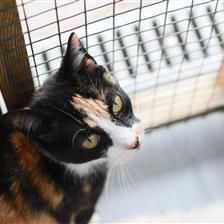|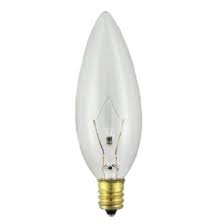|


In [27]:
img_path = './cat.jpg'
x = process_image(img_path, expand_dims=True)

features = saved_model.predict(x)
features

array([[1.000000, 0.000000]], dtype=float32)

In [28]:
img_path = './lightbulb.jpg'
x = process_image(img_path, expand_dims=True)

features = saved_model.predict(x)
features

array([[0.001216, 0.998784]], dtype=float32)

Remember how the first column being equal to 1 meant that there's a cat in the picture, and the second column being equal to 1 meant that there's a lightbulb in the picture? The algorithm returns probabilities for each of the classes. For the cat image we can see it was more than 95% sure that there's a cat in the picture and less than 5% sure it was a lightbulb and vice versa for the lightbulb, meaning both of the predictions were correct. We can also use the validation generator to generate multiple images from our test set to make predictions on:

In [24]:
preds = model.predict_generator(validation_generator, steps=1)

But what's more important, we can use the validation generator to evaluate our model. Remember, the validation generator returns pictures (and slightly modified version of the pictures) that the neural net hasn't seen before!

In [29]:
loss, acc, ce = model.evaluate_generator(validation_generator, steps=5, verbose=0)
loss, acc, ce

(0.001838433789089322, 1.0, 0.018193300813436508)

We can see that the loss for the model is tiny while the accuracy is high, meaning the model performs pretty well on our test set, too! 

Thus, you can see the power of transfer learning - with just 10 images per category we've been able to train an algorithm that can reliably predict if there's a cat or a lightbulb in the picture within a few seconds! Do note that this data set is super small and all the pictures are quite similar, and the performance should get worse with more complex tasks, but still you can see how much faster and more efficient transfer learning can be as opposed to training from scratch!

Keep in mind our example set is quite homogenous (all lighbulbs are presented on their own on a white background), so the algorithm has a harder time predicting different pictures of lightbulbs. For example, this picture of a lighbulb on a black background already poses a bigger challenge to the model:
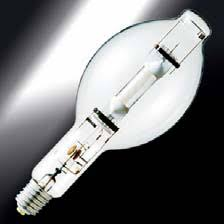

In [31]:
img_path = './lightbullb.jpeg'
x = process_image(img_path, expand_dims=True)

features = saved_model.predict(x)
features

array([[0.316792, 0.683208]], dtype=float32)

As you can see, the algorithm in this case is "only" 68% (in my case - your model can differ) sure that this is a lightbulb and gives it a 31% chance that it's actually a cat. It still gives the right prediction, so that's quite impressive!

Now that you have the basics, go and experiment! Add more pictures, add more classes, go crazy!

If you have any feedback or questions about this tutorial, feel free to reach out to me via [LinkedIn](https://www.linkedin.com/in/csanad-poda)! Happy learning!